In [1]:
import os
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
plt.style.use('seaborn')
import numpy as np


### Cargamos los datos

In [2]:
#path = '../Entrenamientos/result_tramos.xlsx'
path = '../Entrenamientos/Procesado_Tramos.xlsx'

In [26]:
df = pd.read_excel(path)

In [27]:
df.describe()

,tramo,tramo_inicial,tramo_final,pwr,time_seg,dist,spd,viento_aparente,porc,dist_acum
count,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,285.000000,286.000000,286.000000
mean,50.503497,3656.968531,3726.181818,165.837941,137.982517,953.702177,30.246377,-0.335772,inf,50939.603808
std,33.283129,2371.219515,2365.196496,68.757271,293.055632,1556.607132,9.291600,11.029186,NaN,32672.602243
min,0.000000,0.000000,12.000000,0.000000,1.000000,0.000000,0.000000,-22.370389,-6.677410,80.820019
25%,23.250000,1527.000000,1621.000000,111.587865,20.250000,129.987954,24.116650,-8.240294,-1.075459,21661.469741
50%,47.000000,3524.500000,3535.000000,172.968403,56.500000,465.926543,29.889560,-1.853252,-0.013285,49151.450030
75%,71.000000,6057.250000,6167.500000,220.269935,123.750000,900.805662,36.208949,7.204076,1.201687,84649.749962
max,130.000000,7796.000000,7830.000000,394.699287,2761.000000,10273.070042,64.800000,22.925885,inf,107610.184614


In [28]:
df = df[df["viento_aparente"]!=-np.inf]
df = df[df["porc"]!=np.inf]
df["puntos_en_tramo"]= df["tramo_final"]-df["tramo_inicial"]
df = df[df["puntos_en_tramo"]>10]
df = df[df["dist"]>400]

In [29]:
df.describe()

,tramo,tramo_inicial,tramo_final,pwr,time_seg,dist,spd,viento_aparente,porc,dist_acum,puntos_en_tramo
count,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000
mean,49.012422,3508.136646,3623.509317,165.158732,224.726708,1585.665348,30.860261,-0.639284,-0.117919,49515.643817,115.372671
std,34.034172,2377.723077,2372.868233,70.254282,364.389283,1839.789620,9.555359,11.087491,2.824332,32762.364923,135.823268
min,0.000000,0.000000,65.000000,12.155189,40.000000,400.769943,11.200633,-21.077543,-6.677410,624.000000,24.000000
25%,21.000000,1338.000000,1516.000000,103.093380,68.000000,548.000000,23.299345,-8.522427,-2.291880,20391.000000,38.000000
50%,43.000000,3401.000000,3457.000000,174.304985,97.000000,826.669999,29.734666,-1.486806,-0.631580,47516.039935,61.000000
75%,69.000000,5783.000000,6097.000000,222.291330,194.000000,1944.540070,38.131031,6.555296,2.014972,83631.066560,132.000000
max,130.000000,7796.000000,7830.000000,272.819362,2761.000000,10273.070042,52.825966,22.902027,7.137195,107610.184614,796.000000


In [30]:
df.head()

,tramo,tramo_inicial,tramo_final,pwr,time_seg,dist,spd,viento_aparente,porc,dist_acum,prueba,puntos_en_tramo
0,0,0,65,74.149017,106,966.000000,32.807547,6.555296,-3.377386,948.878610,20180406_LEVS_195_90_R_E.gpx,65
1,1,65,432,255.588127,980,4819.000000,17.702449,7.198339,4.181100,5773.000000,20180406_LEVS_195_90_R_E.gpx,367
2,2,432,468,151.469326,44,473.935824,38.776567,8.577246,-1.737873,6248.289894,20180406_LEVS_195_90_R_E.gpx,36
3,3,468,532,249.872906,120,813.223602,24.396708,8.332607,2.662585,7051.000000,20180406_LEVS_195_90_R_E.gpx,64
5,5,548,636,215.967082,170,1271.120011,26.917836,8.057656,1.566720,8533.000000,20180406_LEVS_195_90_R_E.gpx,88


In [31]:
df.head()

,tramo,tramo_inicial,tramo_final,pwr,time_seg,dist,spd,viento_aparente,porc,dist_acum,prueba,puntos_en_tramo
0,0,0,65,74.149017,106,966.000000,32.807547,6.555296,-3.377386,948.878610,20180406_LEVS_195_90_R_E.gpx,65
1,1,65,432,255.588127,980,4819.000000,17.702449,7.198339,4.181100,5773.000000,20180406_LEVS_195_90_R_E.gpx,367
2,2,432,468,151.469326,44,473.935824,38.776567,8.577246,-1.737873,6248.289894,20180406_LEVS_195_90_R_E.gpx,36
3,3,468,532,249.872906,120,813.223602,24.396708,8.332607,2.662585,7051.000000,20180406_LEVS_195_90_R_E.gpx,64
5,5,548,636,215.967082,170,1271.120011,26.917836,8.057656,1.566720,8533.000000,20180406_LEVS_195_90_R_E.gpx,88


In [32]:
from sklearn import datasets, linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [43]:
df_lm = df[['pwr','porc']]
df_lm

,pwr,porc
0,74.149017,-3.377386
1,255.588127,4.181100
2,151.469326,-1.737873
3,249.872906,2.662585
5,215.967082,1.566720
6,80.232099,-1.730661
7,220.019981,2.126107
8,86.025963,-1.471857
9,203.242003,0.946517
10,50.593098,-2.440001


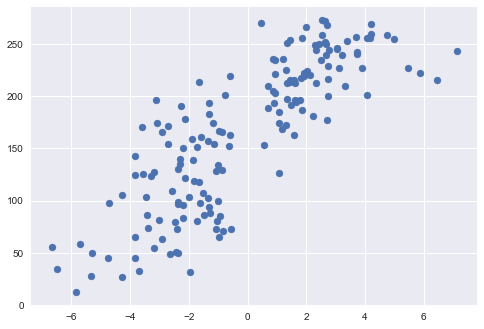

In [45]:
plt.scatter(df_lm['porc'],df_lm['pwr'])

In [51]:
df_lm_x = df_lm[['porc']]
df_lm_y = df_lm[['pwr']]

In [52]:
X_train, X_test, Y_train, Y_test = train_test_split(df_lm_x, df_lm_y, test_size=0.30, random_state=42)

In [53]:
X_train

,porc
33,1.850825
126,-1.817381
15,2.748246
31,1.300215
71,1.345029
7,2.126107
41,1.799504
54,-5.297177
40,-4.284866
17,3.696612


#### Robust Scaler

from sklearn.preprocessing import RobustScaler

model_rs = RobustScaler()

X_train_rs = model_rs.fit_transform(X_train)

X_test_rs = model_rs.transform(X_test)

### Modelo Lineal

In [60]:
from sklearn import linear_model
regr = linear_model.LinearRegression(fit_intercept=True)
regr.fit(X_train,Y_train)

Y_pred = regr.predict(X_test)

In [61]:
print(metrics.mean_squared_error(Y_test,Y_pred))
print(metrics.explained_variance_score(Y_test, Y_pred))

1684.1422508
0.711304043228


In [62]:
regr.coef_

array([[ 20.88552353]])

In [63]:
regr.intercept_

array([ 169.13526271])

In [68]:
X_test

,porc
109,2.536900
113,1.822193
42,-3.191646
17,2.698331
90,-5.830651
44,-2.485578
104,-2.383206
11,4.210450
102,-1.018715
43,4.056833


In [71]:
X_test['Y_poly'] = X_test['porc'].apply(lambda x: x*regr.coef_ + regr.intercept_)

C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [72]:
X_test['Y_pred'] = Y_pred

C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [73]:
X_test

,porc,Y_poly,Y_pred
109,2.536900,[[222.119754404]],222.119754
113,1.822193,[[207.192717004]],207.192717
42,-3.191646,[[102.476075315]],102.476075
17,2.698331,[[225.491326201]],225.491326
90,-5.830651,[[47.359063308]],47.359063
44,-2.485578,[[117.222665471]],117.222665
104,-2.383206,[[119.360749647]],119.360750
11,4.210450,[[257.072715987]],257.072716
102,-1.018715,[[147.858874642]],147.858875
43,4.056833,[[253.864349329]],253.864349


In [74]:
from sklearn.externals import joblib
joblib.dump(regr, "regr_porc_pwr.model")

['regr_porc_pwr.model']